In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chisquare

import matplotlib.pyplot as plt
import seaborn as sn

import os
import pickle
import math

import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
INPUT_DIR = 'data'
USE_MODEL_DIR = '../prosapient_eda/models/universal-sentence-encoder-large_5/'# os.path.join('models', 'universal-sentence-encoder-large_5')
OUTPUT_DIR = 'output'
tf_device = '/CPU:0'

# 1. Load and explore

In [3]:
df = pd.read_csv(os.path.join(INPUT_DIR, 'train-dataset.csv'))

In [4]:
df.head()

,transaction_description,transaction_amount,transaction_account_type,transaction_class
0,ANZ INTERNET BANKING FUNDS TFER TRANSFER 77274...,-5000.00,transaction,transfer
1,VISA DEBIT PURCHASE CARD 4067 VV TRADING PTY L...,-6.50,transaction,payment
2,return 79/12/01 direct debit 374312 elantis pf...,0.15,transaction,refund
3,ATM DEPOSIT HANDYBANK BONDI BEACH 2 23718131 0...,50.00,transaction,transfer
4,POS W/D EATAT153 MERR-08:34,-10.50,transaction,payment


In [5]:
df[['transaction_amount', 'transaction_class']].groupby('transaction_class').describe()

transaction_amount                                         \
                               count         mean           std         min   
transaction_class                                                             
bank-fee                      2991.0  -114.408790    420.281249    -8877.08   
cash-withdrawal               9670.0 -1096.824440   6043.957534  -300000.00   
interest                      8602.0     2.252245     47.590250        0.01   
payment                      37814.0   -96.171395    934.785874  -100000.00   
refund                        7933.0     9.826434    277.961861        0.01   
transfer                     32990.0   153.202348  15624.859308 -2150000.00   

                                                       
                      25%     50%      75%        max  
transaction_class                                      
bank-fee           -15.00   -2.50   -0.965      -0.01  
cash-withdrawal   -500.00 -180.00  -60.000      -0.03  
interest             0.15    0.15    0.150    2943.44  
payment            -50.50  -22.00  -10.000      -0.01  
refund               0.15    0.15    0.150   20529.95  
transfer          -100.00   -1.25  185.000  700000.00

In [6]:

cont_table_type_class = df[['transaction_account_type', 'transaction_class']].pivot_table(values='transaction_account_type',
                                                                                          index='transaction_account_type',
                                                                                          columns='transaction_class',
                                                                                          aggfunc=len).fillna(0)

cont_table_type_class

transaction_class,bank-fee,cash-withdrawal,interest,payment,refund,transfer
transaction_account_type,,,,,,
credit-card,524.0,34.0,0.0,3181.0,4.0,534.0
investment,30.0,1.0,16.0,6.0,1.0,164.0
loan,183.0,22.0,1.0,25.0,0.0,196.0
mortgage,225.0,61.0,0.0,14.0,1.0,269.0
savings,41.0,702.0,8534.0,298.0,7.0,5875.0
term-deposit,0.0,290.0,1.0,0.0,0.0,521.0
transaction,1988.0,8560.0,50.0,34290.0,7920.0,25431.0


In [7]:
chisquare(cont_table_type_class)

Power_divergenceResult(statistic=array([  7103.91975928,  43793.3983454 ,  50666.00720763, 181736.63346909,
        47416.20824404, 111708.98732949]), pvalue=array([0., 0., 0., 0., 0., 0.]))

# 2. Encode transaction_description using Universal Sentence Encoder

In [8]:
with tf.device(tf_device):
    model_use = tf.saved_model.load(USE_MODEL_DIR)


In [9]:
def embed_docs_f(docs, model, batch_size=1000):
    """Converts list od documents to dense vectors"""
    
    if len(docs) > batch_size:
        emb_list = []
        N_batch = math.ceil(len(docs) / batch_size)
        
        for nb in range(N_batch):
            if nb * batch_size % 10000 == 0:
                print(nb * batch_size)
            emb_list.append(model(docs[(nb * batch_size):((nb + 1) * batch_size)]).numpy())
        
        emb_matrix = np.concatenate(emb_list, axis=0)
    else:
        emb_matrix = model(docs).numpy()
            
    return emb_matrix

In [10]:
emb_desc = embed_docs_f(docs=df.transaction_description,
                        model=model_use, batch_size=1000)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [11]:
np.save(os.path.join(OUTPUT_DIR, 'emb_train.npy'), emb_desc)

# 3. Train and test classifier

## 3.1. Train 

In [12]:
emb_desc = np.load(os.path.join(OUTPUT_DIR, 'emb_train.npy'))

In [13]:
is_positive_amount = np.where(df.transaction_amount > 0, 1, 0)[..., np.newaxis]

In [14]:
transaction_type_one_hot = pd.get_dummies(df.transaction_account_type).to_numpy()

In [15]:
X = np.concatenate((emb_desc, 
                    is_positive_amount,
                    transaction_type_one_hot), axis=1)
y = df.transaction_class


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=16)

In [17]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=7)
clf.fit(X_train,y_train)



RandomForestClassifier(n_jobs=7)

In [18]:
pickle.dump(clf, open(os.path.join(OUTPUT_DIR, 'rf_classifier.sav'), 'wb'))


## 3.2. Test and calculate metrics

In [19]:
clf = pickle.load(open(os.path.join(OUTPUT_DIR, 'rf_classifier.sav'), 'rb'))

In [20]:
y_pred = clf.predict(X_test)

In [21]:
print('Accuracy')
print(f'1) test {round(metrics.accuracy_score(y_test, y_pred), 4)}')
print(f'2) train {round(metrics.accuracy_score(y_train, clf.predict(X_train)), 4)}')

Accuracy
1) test 0.9899
2) train 0.9998


In [22]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_labels = y.unique()
cm_labels.sort()

<AxesSubplot:>

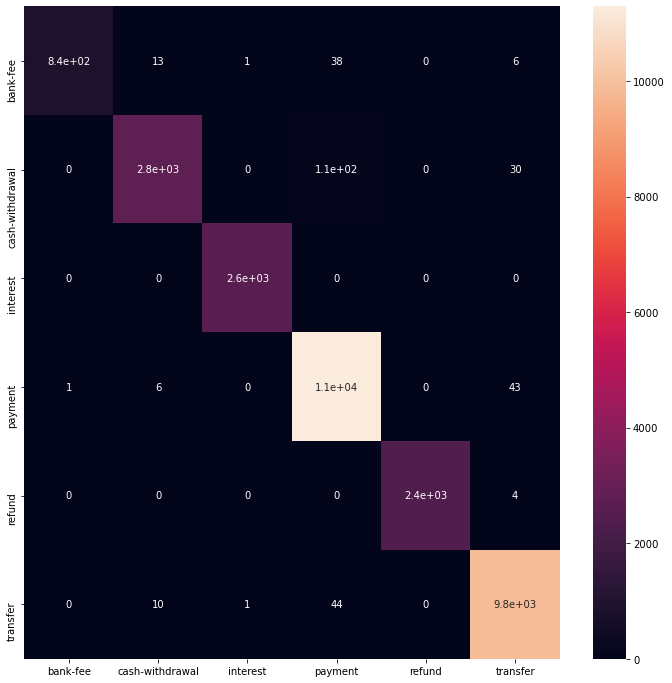

In [23]:
plt.figure(figsize=(12, 12))
sn.heatmap(cm, annot=True, xticklabels=cm_labels, yticklabels=cm_labels)


## F1-scores

### F1 scores for each class

In [24]:
{cm_labels[i]: round(f1, 4) for i, f1 in enumerate(metrics.f1_score(y_test, y_pred, average=None))}

{'bank-fee': 0.966,
 'cash-withdrawal': 0.971,
 'interest': 0.9996,
 'payment': 0.9896,
 'refund': 0.9992,
 'transfer': 0.993}

### Aggregated f1 scores - micro (same as acc), macro, weighted

In [25]:
print(f"F1 micro {round(metrics.f1_score(y_test, y_pred, average='micro'), 4)}")
print(f"F1 macro {round(metrics.f1_score(y_test, y_pred, average='macro'), 4)}")
print(f"F1 weighted {round(metrics.f1_score(y_test, y_pred, average='weighted'), 4)}")

F1 micro 0.9899
F1 macro 0.9864
F1 weighted 0.9898


# 4. Scorecard - transaction class prediction

In [26]:
df_scorecard = pd.read_csv(os.path.join(INPUT_DIR, 'scorecard.csv'))
df_scorecard.head()

,transaction_description,transaction_amount,transaction_account_type
0,0011393060001 Transfer to Macquarie Bank - Rec...,-342.52,transaction
1,0318352 Transfer to Jimboomba Gymnastics Club ...,-157.50,transaction
2,0REGENTVILLE PS 2951 Visa Purchase - Receipt 1...,-49.00,transaction
3,0TUGGERAWONG PS 4097 Visa Purchase - Receipt 1...,-20.00,transaction
4,1001026 Transfer to Blink Property - Receipt 6...,-710.00,transaction


In [27]:
emb_desc_scorecard = embed_docs_f(docs=df_scorecard.transaction_description, model=model_use, batch_size=1000)
is_positive_amount_scorecard = np.where(df_scorecard.transaction_amount > 0, 1, 0)[..., np.newaxis]
transaction_type_one_hot_scorecard = pd.concat(((pd.get_dummies(df.transaction_account_type).iloc[:0].T,
                                                 pd.get_dummies(df_scorecard.transaction_account_type).T)
                                               ), axis=1).fillna(0).T

X_scorecard = np.concatenate((emb_desc_scorecard, 
                              is_positive_amount_scorecard, 
                              transaction_type_one_hot_scorecard), axis=1)

In [28]:
df_scorecard['transaction_class'] = clf.predict(X_scorecard)

In [29]:
df_scorecard['transaction_class'].value_counts()

payment            414
transfer            40
cash-withdrawal     11
refund               1
bank-fee             1
Name: transaction_class, dtype: int64

In [30]:
df_scorecard.to_csv(os.path.join(OUTPUT_DIR, 'scorecard_with_predictions.csv'), index=False)

In [32]:
df[['transaction_amount', 'transaction_class']].groupby('transaction_class').describe()

transaction_amount                                         \
                               count         mean           std         min   
transaction_class                                                             
bank-fee                      2991.0  -114.408790    420.281249    -8877.08   
cash-withdrawal               9670.0 -1096.824440   6043.957534  -300000.00   
interest                      8602.0     2.252245     47.590250        0.01   
payment                      37814.0   -96.171395    934.785874  -100000.00   
refund                        7933.0     9.826434    277.961861        0.01   
transfer                     32990.0   153.202348  15624.859308 -2150000.00   

                                                       
                      25%     50%      75%        max  
transaction_class                                      
bank-fee           -15.00   -2.50   -0.965      -0.01  
cash-withdrawal   -500.00 -180.00  -60.000      -0.03  
interest             0.15    0.15    0.150    2943.44  
payment            -50.50  -22.00  -10.000      -0.01  
refund               0.15    0.15    0.150   20529.95  
transfer          -100.00   -1.25  185.000  700000.00

# Links

Universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder-large/5